In [2]:
import sys
sys.version

'3.7.0 | packaged by conda-forge | (default, Aug 27 2018, 17:24:52) \n[Clang 6.1.0 (clang-602.0.53)]'

In [3]:
from math import log10
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List
from scipy import stats
from scipy.odr import *

In [4]:
# Some important parameters
mu=32e9 # Crustal shear modulus (GPa) in crust

In [5]:
# Here we define all the local classes
@dataclass
class Mech:
    strike: float
    dip: float
    rake: float
@dataclass
class Point:
    lon: float
    lat: float
    dep: float
@dataclass
class SubFault:
    center:Point
    mech:Mech
    slip: float
    length: float
    width: float
    ix: int
    iy: int
    iseg: int
@dataclass
class Fault:
    subs:{int}
@dataclass 
class Segment:
    imin: int
    imax: int
    subs: {int}


# Magnitude scaling relations
Magnitude scaling relations are empirical relations that relate moment magnitude to earthquake dimension such as ruptude length (L), rupture width (W), area (S), average slip (Dave) and occasionally maximum slip (Dmax). One of the earliest and best-known relations are from Wells and Coppersmith (1994). These are for crustal earthquakes, and should not be used for subduction zones. For these, the most commonly used relations are Strasser et al. (2010), Blaser et al. (2010), Murotani et al. (2008). More modern relations are from Ye et al. (2017), Skarlatoudis et al. (2017), Allen and Hayes (2017) and Goda et al. (2016). These more modern relations and the Murotani one are based on slip distributions from finite fault inversions. Scaling relations usually have the following form:

In [6]:
# definitions for scaling relations
@dataclass
class AreaMag:
    a1: float
    b1: float
    Sc: float
    a2: float
    b2: float
def MagFromArea(AM,S):
    if S < AM.Sc:
        return AM.a1+AM.b1*log10(S)
    else:
        return AM.a2+AM.b2*log10(S)
def SlipFromAreaMag(Mw,S,mu0):
    M0=pow(10.,1.5*Mw+9.1)
    return M0/(mu0*S*1e6)
Murotani = AreaMag(4.104,1.0,1.e12,0,0)
Strasser = AreaMag(4.441,0.846,1.e12,0,0)
Goda = AreaMag(2.553,1.283,1.e12,0,0)
Allen = AreaMag(4.6066,0.8197,81021,-7.1935,3.2258)
Skarlatoudis = AreaMag(3.6854,1.0,1e12,0.0,0.0)
Ye = AreaMag(4.13,1.0,1e12,0.0,0.0)


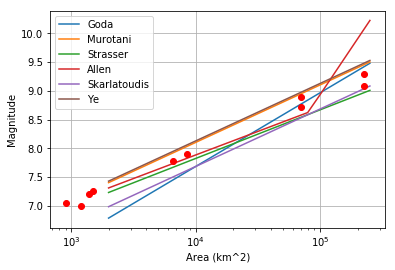

In [7]:
m1=[]
m2=[]
m3=[]
m4=[]
m5=[]
m6=[]
d1=[]
d2=[]
d3=[]
d4=[]
d5=[]
d6=[]
area = []
magy = [7.90, 7.25, 7.05, 7.78, 7.21, 7.00]
Sy = [0.85e4, 0.15e4, 0.09e4, 0.66e4, 0.14e4, 0.12e4]
Dy = [1.66, 0.95, 0.61, 1.28, 0.67, 0.43]
mags = [9.09, 8.72]
Ss=[225000, 70000]
Ds = [4.0, 3.1]
mags1 = [9.3, 8.9]


for i in range (3,25):
    S=pow(10,3+i/10)
    m1.append(MagFromArea(Goda,S))
    m2.append(MagFromArea(Murotani,S))
    m3.append(MagFromArea(Strasser,S))
    m4.append(MagFromArea(Allen,S))
    m5.append(MagFromArea(Skarlatoudis,S)) 
    m6.append(MagFromArea(Ye,S))
    d1.append(SlipFromAreaMag(m1[i-3],S,mu))
    d2.append(SlipFromAreaMag(m2[i-3],S,mu))
    d3.append(SlipFromAreaMag(m3[i-3],S,mu))
    d4.append(SlipFromAreaMag(m4[i-3],S,mu))
    d5.append(SlipFromAreaMag(m5[i-3],S,mu))
    d6.append(SlipFromAreaMag(m6[i-3],S,mu))
    area.append(S)
plt.ylabel("Magnitude")
plt.xlabel("Area (km^2)")
l=plt.semilogx(area,m1,label='Goda')
plt.semilogx(area,m2, label='Murotani')
plt.semilogx(area,m3,label='Strasser')
plt.semilogx(area,m4,label='Allen')
plt.semilogx(area,m5,label='Skarlatoudis')
plt.semilogx(area,m6,label='Ye')
plt.semilogx(Ss,mags,'ro')
plt.setp(l, markersize=30)
plt.setp(l, markerfacecolor='C0')
plt.semilogx(Sy,magy,'ro')
plt.setp(l, markersize=30)
plt.setp(l, markerfacecolor='C0')
plt.semilogx(Ss,mags1,'ro')
plt.setp(l, markersize=30)
plt.setp(l, markerfacecolor='C0')
plt.grid(True)
plt.legend()
plt.show()


# Average slip
Since we already determined an area and magnitude (and thus moment), we can compute the average slip from the traditional definition of the moment magnitude through M0=mu\*S\*Dave:

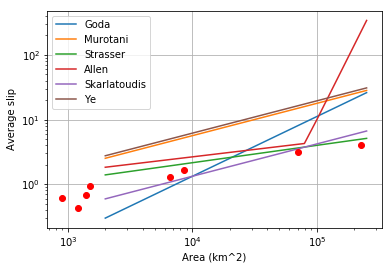

In [8]:
plt.ylabel("Average slip")
plt.xlabel("Area (km^2)")
plt.loglog(area,d1,label='Goda')
plt.loglog(area,d2, label='Murotani')
plt.loglog(area,d3,label='Strasser')
plt.loglog(area,d4,label='Allen')
plt.loglog(area,d5,label='Skarlatoudis')
plt.loglog(area,d6,label='Ye')
plt.loglog(Ss,Ds,'ro')
plt.setp(l, markersize=30)
plt.setp(l, markerfacecolor='C0')
plt.loglog(Sy,Dy,'ro')
plt.setp(l, markersize=30)
plt.setp(l, markerfacecolor='C0')

plt.grid(True)
plt.legend()
plt.show()

0.38290369499441657 -1.4965782792209803


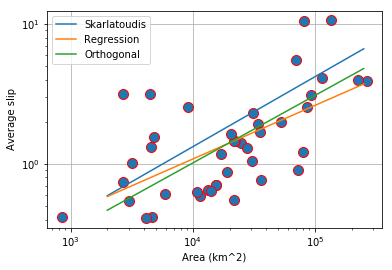

In [9]:
Area_Ska=[]
D_Ska=[]
D_reg=[]
D_orth=[]
S_reg=[]
Log_S=[]
Log_D=[]
with open('/Users/hongkie/Dropbox/Active/Projects/PowellCenter/Scaling/Skarlatoudis/Skarlatoudis-Area-D.xy') as f:
    for line in f:
        a=line.split()
        Area_Ska.append(float(a[0]))
        D_Ska.append(float(a[1]))
        Log_S.append(log10(float(a[0])))
        Log_D.append(log10(float(a[1])))


slope, intercept, r_value, p_value, std_err = stats.linregress(Log_S, Log_D)
print(slope,intercept)
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

linear_model = Model(f) 
data=RealData(Log_S, Log_D)
odr = ODR(data, linear_model, beta0=[0., 1.])
out = odr.run()

# Use the in-built pprint method to give us results.
#out.pprint()
for i in range (3,25):
    S=pow(10,3+i/10)
    S_reg.append(S)
    D_reg.append(pow(10,intercept+slope*log10(S)))
    D_orth.append(pow(10,out.beta[1]+out.beta[0]*log10(S)))


k=plt.loglog(Area_Ska,D_Ska,'ro')
plt.loglog(area,d5,label='Skarlatoudis')
plt.loglog(S_reg,D_reg,label='Regression')
plt.loglog(S_reg,D_orth,label='Orthogonal')
plt.ylabel("Average slip")
plt.xlabel("Area (km^2)")
plt.setp(k, markersize=10)
plt.setp(k, markerfacecolor='C0')
plt.legend()
plt.grid(True)
plt.show()

0.9876510396777249 -4.050343554067548


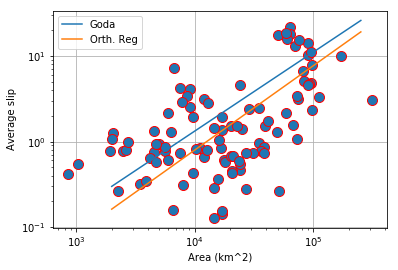

In [10]:
Area_Goda=[]
D_Goda=[]
D_orth=[]
Log_S=[]
Log_D=[]
S_reg=[]
with open('/Users/hongkie/Dropbox/Active/Projects/PowellCenter/Scaling/Goda/Goda-Area-D.xy') as f:
    for line in f:
        a=line.split()
        Area_Goda.append(float(a[0]))
        D_Goda.append(float(a[1]))
        Log_S.append(log10(float(a[0])))
        Log_D.append(log10(float(a[1])))
data=RealData(Log_S, Log_D)
odr = ODR(data, linear_model, beta0=[0., 1.])
out = odr.run()

# Use the in-built pprint method to give us results.
#out.pprint()
print(out.beta[0],out.beta[1])
for i in range (3,25):
    S=pow(10,3+i/10)
    S_reg.append(S)
    D_orth.append(pow(10,out.beta[1]+out.beta[0]*log10(S)))
k=plt.loglog(Area_Goda,D_Goda,'ro')
plt.loglog(area,d1,label='Goda')
plt.loglog(S_reg,D_orth,label='Orth. Reg')
plt.ylabel("Average slip")
plt.xlabel("Area (km^2)")
plt.setp(k, markersize=10)
plt.setp(k, markerfacecolor='C0')
plt.legend()
plt.grid(True)
plt.show()

The spread in the Slip/Area relations (through Mw) is quite large, which may be due to the fact that the individual regressions versus Mw are independent. I think only Leonard has performed self-consistent regressions. So the next step will be to see if we can directly derive Slip/Area regressions.

# The Alaska-Aleutian subduction zone model
The geometry of the ASCE/CGS model for the Alaska-Aleutian subduction zone is based on Slab1.0 (Hayes et al.,2012). Belows, we will read in the file:

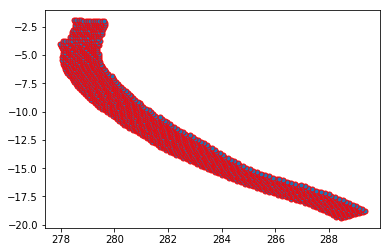

In [11]:
# Read in the Alaska subfaults in i_invall format
SF=[]
i=0
with open('/Users/hongkie/Dropbox/Active/Projects/LimaAirport/Sources/Interface/i_invall-Peru_S2.0v1-trimmed') as f:
    for line in f:
        a=line.split()
        b=[int(a[i]) for i in range(9,12)]
        a=[float(a[i]) for i in range(9)]
        SF.append(SubFault(Point(a[0],a[1],a[2]),Mech(a[3],a[4],a[5]),a[6],a[7],a[8],b[0],b[1],b[2]))
        i=i+1
nsub=i-1
longitude=[]
latitude=[]
for i in range (1,nsub):
    longitude.append(SF[i].center.lon)
    latitude.append(SF[i].center.lat)   
l = plt.plot(longitude, latitude, 'ro')
plt.setp(l, markersize=5)
plt.setp(l, markerfacecolor='C0')
plt.show()

# Subfaults
The entire subduction zone interface has been discretized into small semi-rectanular elemental faults called subfaults, shown above. The dimensions are chosen to be small enough so that they can be used as building blocks any size earthquake of interest and also to adequately represent complexities in the interface geometry. When defining fault segments (see below), we use the subfault indices to delineate the different segments.

# Segmentation
<p>Segmentation is the division of a larger fault zone into smaller sections that rupture independently of each other. Segments are not to be confused with subfaults, which are smaller still. Our definition and use of fault segments reflects the rupture extent of past earthquakes (or absence of) but also arises from practical considerations, because it facilitates the interpretation of along-strike variations in recurrence and slip rates. In our appraoch, larger earthquakes that exceed single segment are accounted for by allowing events that consist of multiple segments.</p>
In the ASCE7-16/CGS maps we based our segmentation on the Jacobs and Nishenko (1990) model becaue of the relatively small size of the individual segments, compared to, for instance, the USGS, 2007 model (Wesson et al., 2007).
<p>This segmentation is presented below:</p>

In [120]:
#nseg=12
#min=[0, 3, 10, 16, 23, 27, 32, 43, 48, 52, 60, 66]
#max=[2, 9, 15, 22, 26, 31, 42, 47, 51, 59, 65, 68]
#retp=[1200, 600, 300, 250, 3000, 180, 400, 150, 150, 200, 200, 1000 ]
#rate=[]
#Seg=["Yakataga","PWS","Kodiak","Semidi","Shumagin","Unimak","Fox","Andreanof","Delarof","Rat","New","Komandorski"]
#Se={'Ya':0,'PW':1,'Ko':2,'Se':3,'Sh':4,'Un':5,'Fo':6,'An':7,'De':8,'Ra':9,'Ne':10,'Km':11}
nseg=3
min=[0, 3, 10, 16, 23, 27, 32, 43, 48, 52, 60, 66]
max=[2, 9, 15, 22, 26, 31, 42, 47, 51, 59, 65, 68]
retp=[1200, 600, 300, 250, 3000, 180, 400, 150, 150, 200, 200, 1000 ]
rate=[]
Seg=["South","Central","North","Semidi","Shumagin","Unimak","Fox","Andreanof","Delarof","Rat","New","Komandorski"]
Se={'Ya':0,'PW':1,'Ko':2,'Se':3,'Sh':4,'Un':5,'Fo':6,'An':7,'De':8,'Ra':9,'Ne':10,'Km':11}
print(SF[1])
for i in Se:
    rate.append(1./retp[Se[i]])
    for j in range (nsub):
        if(SF[j].ix >= min[Se[i]] and SF[j].ix <= max[Se[i]]):
            SF[j].iseg=Se[i]
print(j,SF[nsub])
    

SubFault(center=Point(lon=216.934, lat=60.659, dep=2.8), mech=Mech(strike=-121.1, dip=4.9, rake=87.5), slip=100.0, length=57.84, width=24.95, ix=0, iy=1, iseg=0)
363 SubFault(center=Point(lon=169.572, lat=53.691, dep=22.9), mech=Mech(strike=305.45, dip=25.27, rake=91.03), slip=100.0, length=39.1, width=26.0, ix=68, iy=3, iseg=-1)


# Glossary:
a, b are typically used in the scaling relations
L, W, Dave, Dmax, S are length, width, average slip, maximum slip and area ofr an earthquake rupture


# References:
<p>Allen, T.I. and Hayes, G.P., 2017. Alternative Rupture‐Scaling Relationships for Subduction Interface and Other Offshore Environments:, doi: 10.1785/0120160255.</p>
<p>Blaser, L., Kruger, F., Ohrnberger, M. and Scherbaum, F., 2010. Scaling Relations of Earthquake Source Parameter Estimates with Special Focus on Subduction Environment: 100, p. 2914–2926, doi: 10.1785/0120100111.</p>
<p>Hayes, G.P., Wald, D.J. and Johnson, R.L., 2012. Slab1.0: A three-dimensional model of global subduction zone geometries: Journal of Geophysical Research: Solid Earth, 117, p. B01302, doi: 10.1029/2011JB008524.</p>
<p>Murotani, S., Miyake, H. and Koketsu, K., 2008. Scaling of characterized slip models for plate-boundary earthquakes: Earth, Planets and Space, 60, p. 987.</p>
<p>Nishenko, S.P. and Jacob, K.H., 1990. Seismic potential of the Queen Charlotte‐Alaska‐Aleutian Seismic Zone: Journal of Geophysical Research: Solid Earth, 95, p. 2511–2532, doi: 10.1029/JB095iB03p02511.</p>
<p>Papazachos, B., Scordilis, E., Panagiotopoulos, D., Papazachos, C.B. and Karakaisis, G.F., 2004. Global relations between seismic fault parameters and moment magnitude of earthquakes: Bulletin of the Geological Society of Greece, 36, p. 1482–1489.</p>
<p>Strasser, F.O., Arango, M.C. and Bommer, J.J., 2010. Scaling of the Source Dimensions of Interface and Intraslab Subduction-zone Earthquakes with Moment Magnitude: Seismological Research Letters, 81, p. 941–950, doi: 10.1785/gssrl.81.6.941.</p>
<p>Wells, D.L. and Coppersmith, K.J., 1994. New empirical relationships among magnitude, rupture length, rupture width, rupture area, and surface displacement: 84, p. 974–1002.</p>
<p>Wesson, R.L., Boyd, O.S., Mueller, C.S., Bufe, C.G., Frankel, A.D. and Petersen, M.D., 2007. Revision of time-independent probabilistic seismic hazard maps for Alaska: US Department of the Interior, US Geological Survey Open File Report 2007–1043.</p>
